# Assignment 2: Classification Analysis

## Dataset: Phishing Websites Dataset

**Selected Dataset**: UCI Phishing Websites Dataset (ID: 327)

**Classification Task**: Binary classification to detect phishing websites vs legitimate websites


In [11]:
def brute_froce_LOO(X_train, y_train, X_test, y_test, idx_list, ap_baseline):

    print("Brute Force LOO Running...")

    records = []
    for i in idx_list:
        mask = np.ones(X_train.shape[0], dtype=bool)
        mask[i] = False
        X_tr, y_tr = X_train[mask], y_train[mask]

        rf = RandomForestClassifier(n_estimators=300, random_state=7, n_jobs=-1)
        rf.fit(X_tr, y_tr)
        proba = rf.predict_proba(X_test)[:, 1]
        ap_loo = average_precision_score(y_test, proba)
        impact = ap_baseline - ap_loo

        records.append({"train_idx": i, "AP_full": ap_baseline, "AP_LOO": ap_loo, "Impact": impact})
        print(f"Removed train idx {i} | AP_LOO={ap_loo:.4f} | Impact={impact:+.4f}")

    df = pd.DataFrame(records).sort_values(by="Impact", ascending=False).reset_index(drop=True)

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(df)), df["Impact"])
    plt.xticks(range(len(df)), df["train_idx"].astype(str), rotation=45, ha="right")
    plt.ylabel("Impact (AP_full - AP_LOO)")
    plt.title("LOO Impact on AP using RandomForest")
    plt.tight_layout()
    plt.show()

    print("\nBrute Force LOO Result")
    print(df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
    return df

In [12]:
def confusion_matrix_plot(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    ax.imshow(cm, interpolation="nearest", cmap="Blues")

    ticks = np.arange(len(labels))
    ax.set_xticks(ticks); ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticks(ticks); ax.set_yticklabels(labels)

    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), ha="center", va="center")
    fig.tight_layout()
    plt.show()

In [13]:
def pr_curve_binary(y_true, proba, title="Precision-Recall Curve"):
    precision, recall, _ = precision_recall_curve(y_true, proba)
    ap = average_precision_score(y_true, proba)
    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, lw=2, label=f"AP={ap:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return ap

In [14]:
def roc_curve_binary(y_true, proba, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, proba)
    auc = roc_auc_score(y_true, proba)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, lw=2, label=f"AUC={auc:.3f}")
    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return auc


In [15]:
def train_eval(model_name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc  = accuracy_score(y_test, y_pred)
    f1m  = f1_score(y_test, y_pred, average="macro")

    print(f"\n{model_name} is trained and evaluated")
    print(f"Accuracy: {acc:.4f} | F1(macro): {f1m:.4f}")
    print(classification_report(y_test, y_pred, target_names=["Legit", "Phishing"], digits=4))

    proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    ap = average_precision_score(y_test, proba) if proba is not None else np.nan
    rocauc = roc_auc_score(y_test, proba) if proba is not None else np.nan
    print(f"AP(PR-AUC): {ap:.4f} | ROC-AUC: {rocauc:.4f}")

    return (model_name, y_pred, proba, acc, f1m, ap, rocauc)

## 1. Import Libraries and Load Dataset (2 marks)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score, roc_auc_score, roc_curve
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

### 1.1 Load Dataset
Loading the Phishing Websites dataset from UCI repository.

In [38]:

phishing_websites = fetch_ucirepo(id=327)
X = phishing_websites.data.features.values
y = phishing_websites.data.targets.values.ravel()
y = np.where(y == -1, 0, 1)
labels = ["Legit", "Phishing"]
print(f"Dataset shape: {X.shape}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Class distribution:\n{pd.Series(y).value_counts()}")
feature_names = phishing_websites.data.features.columns.tolist()
print("\\n=== Feature Names ===")
print(feature_names)
print(f"\\nTotal features: {len(feature_names)}")


Dataset shape: (11055, 30)
Number of samples: 11055
Number of features: 30
Class distribution:
1    6157
0    4898
Name: count, dtype: int64
\n=== Feature Names ===
['having_ip_address', 'url_length', 'shortining_service', 'having_at_symbol', 'double_slash_redirecting', 'prefix_suffix', 'having_sub_domain', 'sslfinal_state', 'domain_registration_length', 'favicon', 'port', 'https_token', 'request_url', 'url_of_anchor', 'links_in_tags', 'sfh', 'submitting_to_email', 'abnormal_url', 'redirect', 'on_mouseover', 'rightclick', 'popupwindow', 'iframe', 'age_of_domain', 'dnsrecord', 'web_traffic', 'page_rank', 'google_index', 'links_pointing_to_page', 'statistical_report']
\nTotal features: 30


This dataset is used to identify whether a website is phishing or legitimate. The dataset contains 11,055 samples with 30 features extracted from various website characteristics. The dataset is fairly balanced, with a slight skew toward phishing websites.

## 2. Process Features and Labels (2 marks)
 The dataset contains 30 numerical features extracted from website characteristics, including:
 - URL-based features: having_ip_address, url_length, shortining_service, having_at_symbol, double_slash_redirecting, prefix_suffix, url_of_anchor, links_in_tags, request_url
- Domain-based features: having_sub_domain, sslfinal_state, domain_registration_length, age_of_domain, dnsrecord, web_traffic, page_rank, google_index
- HTML/JavaScript-based features: favicon, port, https_token, sfh, submitting_to_email, abnormal_url, redirect, on_mouseover, rightclick, popupwindow, iframe, links_pointing_to_page, statistical_report
All features are numeric, and the target variable is binary (0: legitimate, 1: phishing).

## 3.Train/Test Split (2 marks)
**Split strategy**: 75/25 stratified random split
- Training set: 75% of data
- Test set: 25% of data
- Random state: 42 for reproducibility

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
# Standardize numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


## 4. Train Classifiers (2 marks)

**Selected models**:
1. **K-Nearest Neighbors (KNN)**
We started with KNN as a simple baseline since it's non-parametric and doesn't make assumptions about the data. It's useful to see if similar websites cluster together in the feature space. If phishing sites share similar characteristics, KNN should be able to identify them based on their neighbors..
2. **Logistic Regression**
We Chose this as a linear baseline to test if there's a linear relationship between features and the target. It's also super fast.
**After selecting 2 fairly simple models, we decided to try out more complex models.**
3. **Support Vector Machine (SVC)**
After testing simpler models, I wanted to try something that can capture non-linear patterns. Since we have 30 features, SVMs work well in higher dimensions. The RBF kernel lets it learn more complex decision boundaries between phishing and legitimate sites.
4. **Random Forest**
Picked Random Forest because ensemble methods are usually robust and handle overfitting well. It works well with this type of structured tabular data and doesn't need much tuning. Also useful if I want to check feature importance later.

In [19]:

models = [
    ("KNN", KNeighborsClassifier(n_neighbors=15)),
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=7, class_weight="balanced")),
    ("SVC", SVC(kernel="rbf", probability=True, random_state=7, class_weight="balanced")),
    ("Random Forest", RandomForestClassifier(n_estimators=300, random_state=7, n_jobs=-1)),
]

results = []
for name, model in models:
    results.append(train_eval(name, model, X_train_scaled, X_test_scaled, y_train, y_test))


KNN is trained and evaluated
Accuracy: 0.9392 | F1(macro): 0.9385
              precision    recall  f1-score   support

       Legit     0.9286    0.9347    0.9317      1225
    Phishing     0.9477    0.9428    0.9453      1539

    accuracy                         0.9392      2764
   macro avg     0.9382    0.9388    0.9385      2764
weighted avg     0.9393    0.9392    0.9392      2764

AP(PR-AUC): 0.9849 | ROC-AUC: 0.9849

Logistic Regression is trained and evaluated
Accuracy: 0.9287 | F1(macro): 0.9278
              precision    recall  f1-score   support

       Legit     0.9186    0.9208    0.9197      1225
    Phishing     0.9368    0.9350    0.9359      1539

    accuracy                         0.9287      2764
   macro avg     0.9277    0.9279    0.9278      2764
weighted avg     0.9287    0.9287    0.9287      2764

AP(PR-AUC): 0.9851 | ROC-AUC: 0.9815

SVC is trained and evaluated
Accuracy: 0.9541 | F1(macro): 0.9533
              precision    recall  f1-score   support



## 5. Performance Evaluation

### Primary Metric: Average Precision (AP) (2 marks)
**Choice**: We chose Average Precision (area under the precision-recall curve) as the primary metric for this phishing detection task. It means "Of all the sites we flagged as phishing, how many were actually phishing?"

In phishing detection, false negatives (missing a phishing site) are more dangerous than false positives (flagging a legitimate site). Users visiting undetected phishing sites could have serious problems, while false positives just cause minor inconvenience. AP emphasizes the model's ability to correctly identify phishing sites at various thresholds.




In [20]:

best = max(results, key=lambda t: t[5])
print(f"Best by AP: {best[0]} | AP={best[5]:.4f}")
best_model_name, best_pred, best_proba, best_acc, best_f1m, best_ap, best_rocauc = best
print(f"\nBest model by AP: {best_model_name} | AP={best_ap:.4f} | F1m={best_f1m:.4f} | Acc={best_acc:.4f}")

Best by AP: Random Forest | AP=0.9983

Best model by AP: Random Forest | AP=0.9983 | F1m=0.9743 | Acc=0.9747


### Confusion Matrix

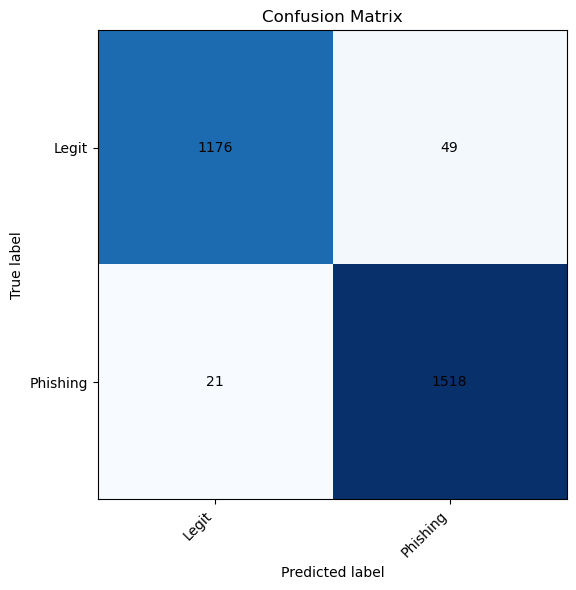

In [21]:
confusion_matrix_plot(y_test, best_pred, labels)

### Precision-Recall Curve

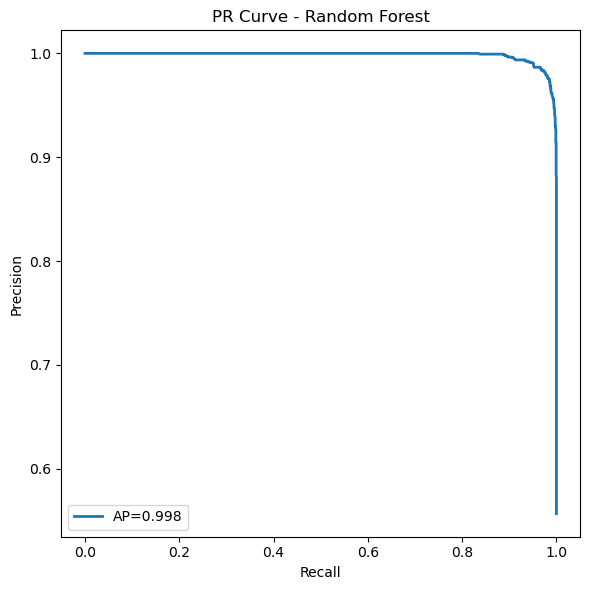

0.998286347905662

In [22]:
pr_curve_binary(y_test, best_proba, title=f"PR Curve - {best_model_name}")

### ROC Curve

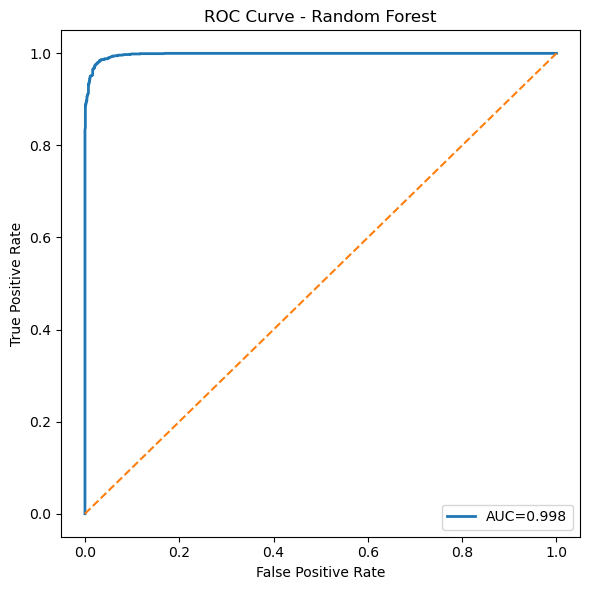

0.9978509766479692

In [23]:
roc_curve_binary(y_test, best_proba, title=f"ROC Curve - {best_model_name}")

## Part 2: Brute Force LOO Influence (8 marks)

Brute Force LOO Running...
Removed train idx 0 | AP_LOO=0.9982 | Impact=+0.0000
Removed train idx 799 | AP_LOO=0.9983 | Impact=-0.0000
Removed train idx 1599 | AP_LOO=0.9983 | Impact=-0.0000
Removed train idx 2399 | AP_LOO=0.9983 | Impact=-0.0000
Removed train idx 3199 | AP_LOO=0.9982 | Impact=+0.0000
Removed train idx 3999 | AP_LOO=0.9983 | Impact=+0.0000
Removed train idx 4799 | AP_LOO=0.9983 | Impact=+0.0000
Removed train idx 5599 | AP_LOO=0.9983 | Impact=+0.0000
Removed train idx 6399 | AP_LOO=0.9983 | Impact=-0.0000
Removed train idx 7199 | AP_LOO=0.9983 | Impact=+0.0000


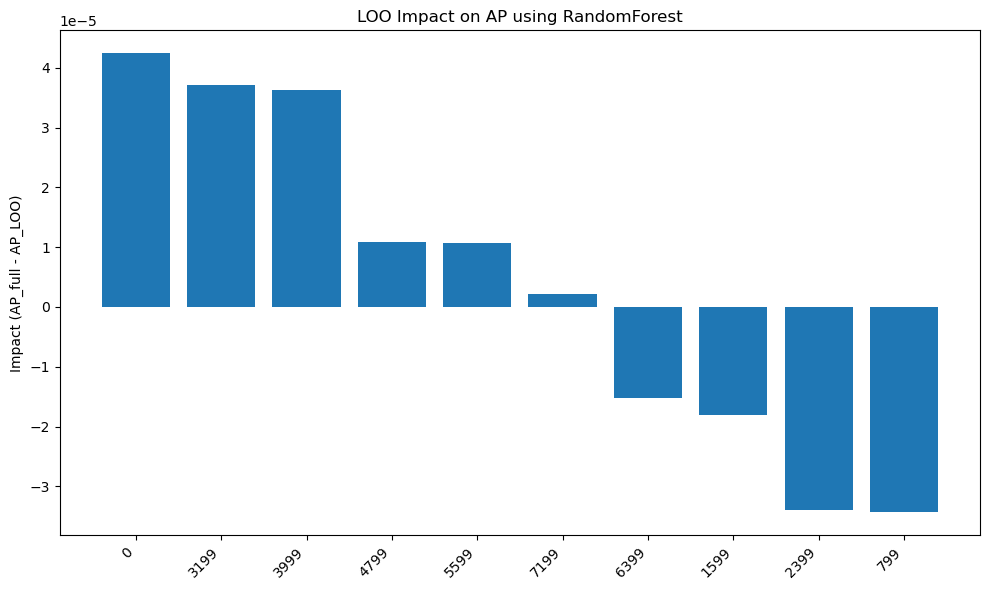


Brute Force LOO Result
 train_idx  AP_full  AP_LOO  Impact
         0   0.9983  0.9982  0.0000
      3199   0.9983  0.9982  0.0000
      3999   0.9983  0.9983  0.0000
      4799   0.9983  0.9983  0.0000
      5599   0.9983  0.9983  0.0000
      7199   0.9983  0.9983  0.0000
      6399   0.9983  0.9983 -0.0000
      1599   0.9983  0.9983 -0.0000
      2399   0.9983  0.9983 -0.0000
       799   0.9983  0.9983 -0.0000


,train_idx,AP_full,AP_LOO,Impact
0,0,0.998286,0.998244,0.000042
1,3199,0.998286,0.998249,0.000037
2,3999,0.998286,0.998250,0.000036
3,4799,0.998286,0.998275,0.000011
4,5599,0.998286,0.998276,0.000011
5,7199,0.998286,0.998284,0.000002
6,6399,0.998286,0.998302,-0.000015
7,1599,0.998286,0.998304,-0.000018
8,2399,0.998286,0.998320,-0.000034
9,799,0.998286,0.998321,-0.000034


In [24]:
idx_list = [0, 799, 1599, 2399, 3199, 3999, 4799, 5599, 6399, 7199]
brute_froce_LOO(X_train_scaled, y_train, X_test_scaled, y_test, idx_list, best_ap)

### Analysis of LOO Influence Scores
**Overall observation:** The influence scores are really small. They're all in the range of like 0.00004. This means removing any single training point barely affects the model's AP. The Random Forest is pretty stable, which makes sense since it's trained on over 8,000 samples with 300 trees.

**Positive influence samples(indices 0, 3199, 3999, 4799, 5599, 7199):** These have small positive impacts. When I remove them, the AP goes down slightly, so they're helping the model a bit. Sample 0 has the highest positive influence at +0.00004, though it's still tiny. These might just be clear, well-classified examples that fit the patterns well.

**Negative influence samples (indices 799, 1599, 2399, 6399):** These have negative impacts—when removed, the AP actually goes up a tiny bit. This could mean they're:
- Borderline cases that are hard to classify
- Slightly noisy or confusing examples
- Maybe close to the decision boundary
The most negative is sample 799 at -0.00004, but again, it's such a small change that it's not really concerning.

The model is robust. Even the "most influential" samples barely change the performance, which is good for a real-world application. It means the model isn't overly dependent on specific training examples.

## Part 3: Group-level influence (8 marks)

In [25]:
def group_leave_out(X_train, y_train, X_test, y_test, group_sizes, ap_baseline):
    records = []
    np.random.seed(42)
    for group_size in group_sizes:
        n_samples = int(len(X_train) * group_size / 100)

        remove_indices = np.random.choice(len(X_train), n_samples, replace=False)
        keep_mask = np.ones(len(X_train), dtype=bool)
        keep_mask[remove_indices] = False

        # Train model without this group
        X_tr, y_tr = X_train[keep_mask], y_train[keep_mask]

        rf = RandomForestClassifier(n_estimators=300, random_state=7, n_jobs=-1)
        rf.fit(X_tr, y_tr)
        proba = rf.predict_proba(X_test)[:, 1]
        ap_without = average_precision_score(y_test, proba)
        influence = ap_baseline - ap_without

        records.append({
            "group_size_pct": group_size,
            "group_size_n": n_samples,
            "AP_full": ap_baseline,
            "AP_without": ap_without,
            "influence": influence
        })
        print(f"Group size {group_size}% ({n_samples} samples) | AP={ap_without:.4f} | Influence={influence:+.4f}")

    df = pd.DataFrame(records)

    plt.figure(figsize=(10, 6))
    plt.plot(df["group_size_pct"], df["influence"], marker='o', linewidth=2, markersize=8)
    plt.xlabel("Group Size (%)", fontsize=12)
    plt.ylabel("Influence (AP_full - AP_without)", fontsize=12)
    plt.title("Group-Level Influence: Impact of Removing Training Data Groups", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(df["group_size_n"], df["influence"], marker='o', linewidth=2, markersize=8, color='orange')
    plt.xlabel("Group Size (Number of Samples)", fontsize=12)
    plt.ylabel("Influence (AP_full - AP_without)", fontsize=12)
    plt.title("Group-Level Influence vs Absolute Group Size", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()




Group size 5% (414 samples) | AP=0.9981 | Influence=+0.0002
Group size 10% (829 samples) | AP=0.9981 | Influence=+0.0001
Group size 15% (1243 samples) | AP=0.9976 | Influence=+0.0007
Group size 20% (1658 samples) | AP=0.9973 | Influence=+0.0010
Group size 30% (2487 samples) | AP=0.9968 | Influence=+0.0015
Group size 40% (3316 samples) | AP=0.9941 | Influence=+0.0042
Group size 50% (4145 samples) | AP=0.9961 | Influence=+0.0022
Group size 60% (4974 samples) | AP=0.9952 | Influence=+0.0031
Group size 70% (5803 samples) | AP=0.9942 | Influence=+0.0041
Group size 80% (6632 samples) | AP=0.9920 | Influence=+0.0063


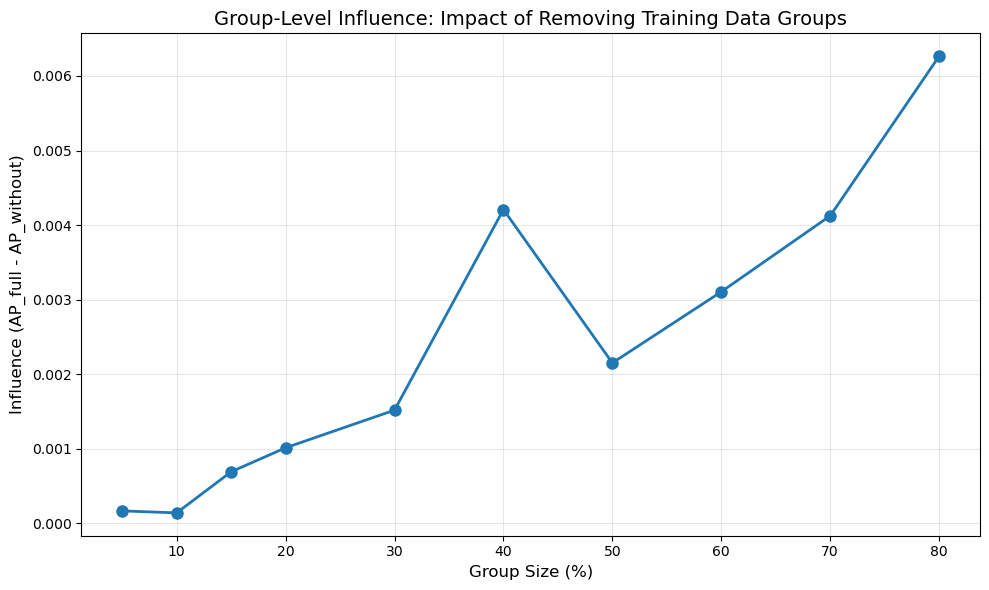

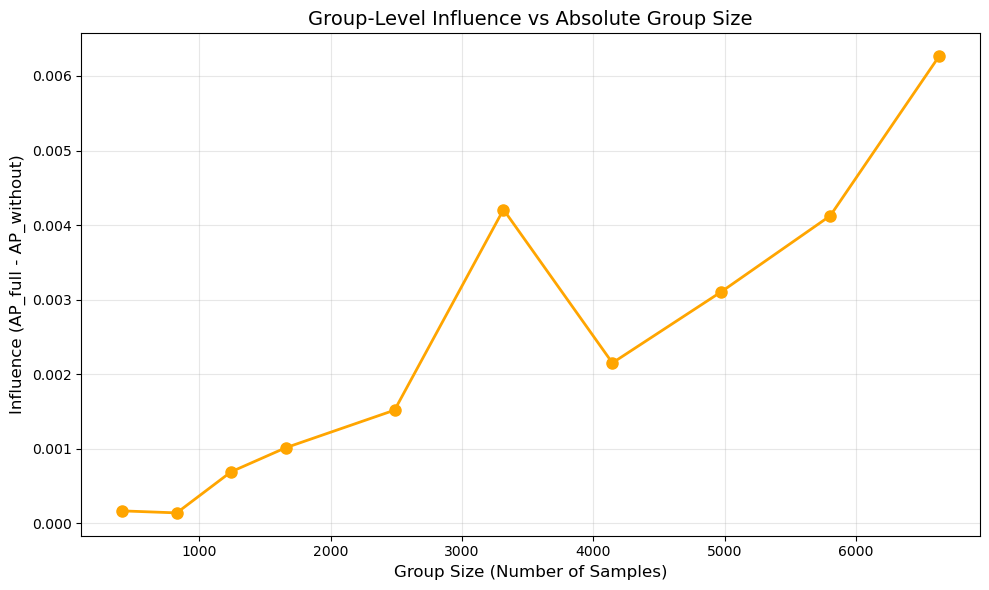

In [26]:
group_sizes = [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]

# Run group-level analysis
group_results = group_leave_out(
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test,
    group_sizes,
    best_ap
)

### Analysis of Group-Level Influence

**Overall trend:** As expected, larger groups generally have bigger influence on model performance. Removing more training data leads to larger drops in AP, which makes sense—less data means the model has less information to learn from.

**Small groups (5-20%):** Have relatively small influence (0.0001 to 0.0010), showing the model is pretty resilient with over 6,000+ remaining samples.

**Medium groups (30-50%):** Influence starts increasing more noticeably.Interestingly, there's a spike at 40%, then it drops back down at 50%. This is unexpected and could be due to the 40% group might have included more "informative" samples by chance

**Large groups (60-80%):** Influence starts to increase even more. At 80% removal, the influence jumps to 0.0063. Training with only 20% of the data clearly hurts performance more significantly.

## Part 4: Shapley values (8 marks)


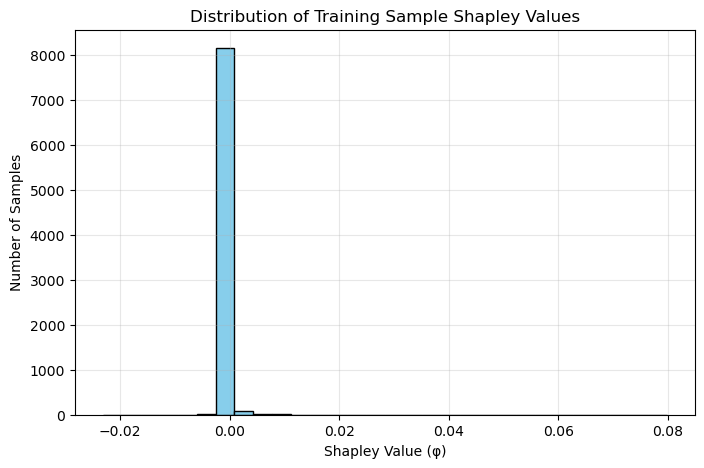

In [40]:
def performance(S_index):
    if len(S_index) == 0:
        return 0.0
    
    if len(np.unique(y_train[S_index])) < 2:
        return 0.0

    model = LogisticRegression(
        max_iter=1000,          
        random_state=7,         
        class_weight="balanced" 
    )
    
    model.fit(X_train[S_index], y_train[S_index])
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

def tmc_shapley(X_train, y_train, num_perm=10, tolerance=0.001):
    n = len(X_train)
    shapley_values = np.zeros(n)
    full_performance = performance(np.arange(n))   

    for t in range(num_perm):            
        perm = np.random.permutation(n)
        previous_performance = performance([])        

        for j in range(n):              
            if abs(full_performance - previous_performance) < tolerance:
                break                   

            subset = perm[:j+1]          
            current_performance = performance(subset) 
            shapley_values[perm[j]] += (current_performance - previous_performance) 
            previous_performance = current_performance

    shapley_values /= num_perm                      
    return shapley_values

shapley_values = tmc_shapley(X_train, y_train, num_perm=10, tolerance=0.001)

plt.figure(figsize=(8, 5))
plt.hist(shapley_values, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Training Sample Shapley Values")
plt.xlabel("Shapley Value (φ)")
plt.ylabel("Number of Samples")
plt.grid(alpha=0.3)
plt.show()

**Observation:** The vast majority of training samples have Shapley values extremely close to zero. Almost all values are concentrated in a very narrow range around 0. The histogram shows a sharp peak at 0 with over 8,000 samples clustered there. Nearly all training points have Shapley values between approximately -0.005 and +0.005. This means most individual samples contribute very little to the model's overall performance. There are no samples with notably high positive or negative Shapley values. The distribution doesn't show any long tails, which would indicate particularly valuable or harmful training examples.

This pattern is actually consistent with what we saw in Part 2 (LOO influence). Both analyses show that individual training samples have very small impact on model performance.

### Contribution Statement
Danny:

- Selected the phishing websites dataset (Part 1)
- Implemented and analyzed Group-level influence (Part 3)
- Contributed to Shapley values implementation and analysis (Part 4)

Warren:

- Selected and implemented the classification models (Part 1)
- Implemented and analyzed Brute force LOO influence (Part 2)
- Contributed to Shapley values implementation and analysis (Part 4)

Both members collaborated on the overall report structure, code review, and final analysis interpretation.